# Import

In [1]:
import torchvision
from torchvision import transforms

In [2]:
from PIL import Image

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Dataset

https://www.kaggle.com/datasets/robikscube/textocr-text-extraction-from-images-dataset

https://textvqa.org/textocr/dataset/

In [5]:
with open('TextOCR_0.1_train.json', 'r') as file:
    train_anot = json.load(file)

In [6]:
with open('TextOCR_0.1_val.json', 'r') as file:
    val_anot = json.load(file)

In [7]:
def convert_box_point(box):
    return [box[0], box[1], box[0]+box[2], box[1]+box[3]]

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
class TextOCR(Dataset):
    def __init__(self, anot, path: str, transforms=None):
        self.imgs = anot['imgs']
        self.anns = anot['anns']
        self.path = path
        self.transforms = transforms
        
        self.files = list(self.imgs.keys())
        
        boxes = dict()
        texts = dict()
        for key, value in anot['anns'].items():
            # convert to format 0 <= x_min < x_max < width, 0 <= y_min < y_max < height
            bbox = convert_box_point(value['bbox'])
            if value['image_id'] not in boxes:
                boxes[value['image_id']] = [bbox]
                texts[value['image_id']] = [value['utf8_string']]
            else:
                boxes[value['image_id']].append(bbox)
                texts[value['image_id']].append(value['utf8_string'])
        
        self.boxes = boxes
        self.texts = texts
        

    def __getitem__(self, index: int):
        image_id = self.files[index]
        
        image = Image.open(self.path + self.imgs[image_id]['file_name'].replace('train', 'train_images')).convert('RGB')
        original_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)

        if self.transforms is not None:
            image = self.transforms(image)
        
        boxes = self.boxes[image_id]
        boxes = torch.as_tensor(boxes, dtype=torch.float32) / original_dims
        texts = self.texts[image_id]
        
        return image, boxes, texts
    
    def __len__(self):
        return len(self.files)

In [10]:
transform_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

transform_to_pil_img = transforms.Compose([
    transforms.ToPILImage()
])

In [11]:
def plot_image(image, boxes: list, texts: list):    
    drawn_boxes = []

    img = transform_to_tensor(image) * 255
    img = torch.tensor(img, dtype=torch.uint8, requires_grad=False)
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    texts = [text.encode('utf-8') for text in texts]

    drawn_boxes.append(
        torchvision.utils.draw_bounding_boxes(
            img,
            boxes,
            labels=texts,
            colors=['blue'] * len(boxes),
            width=2,
            font_size=25,
        )
    )

    drawn_boxes = [transform_to_pil_img(img) for img in drawn_boxes]

    plt.figure(figsize=(16,16))
    plt.imshow(drawn_boxes[0])
    plt.axis('off')
    plt.show()

In [12]:
img_id = '0b9e647fccd97986'
boxes = []
labels = []
for key, val in train_anot['anns'].items():
    if val['image_id'] == img_id:
        box = convert_box_point(val['bbox'])
        boxes.append(box)
        labels.append(val['utf8_string'])

In [13]:
image = Image.open(f'Downloads/train_images/{img_id}.jpg').convert('RGB')

/var/folders/3p/wz2sjqtx3vz8szc7z3qdgtl4fvlwb6/T/ipykernel_2456/3370322586.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.uint8, requires_grad=False)


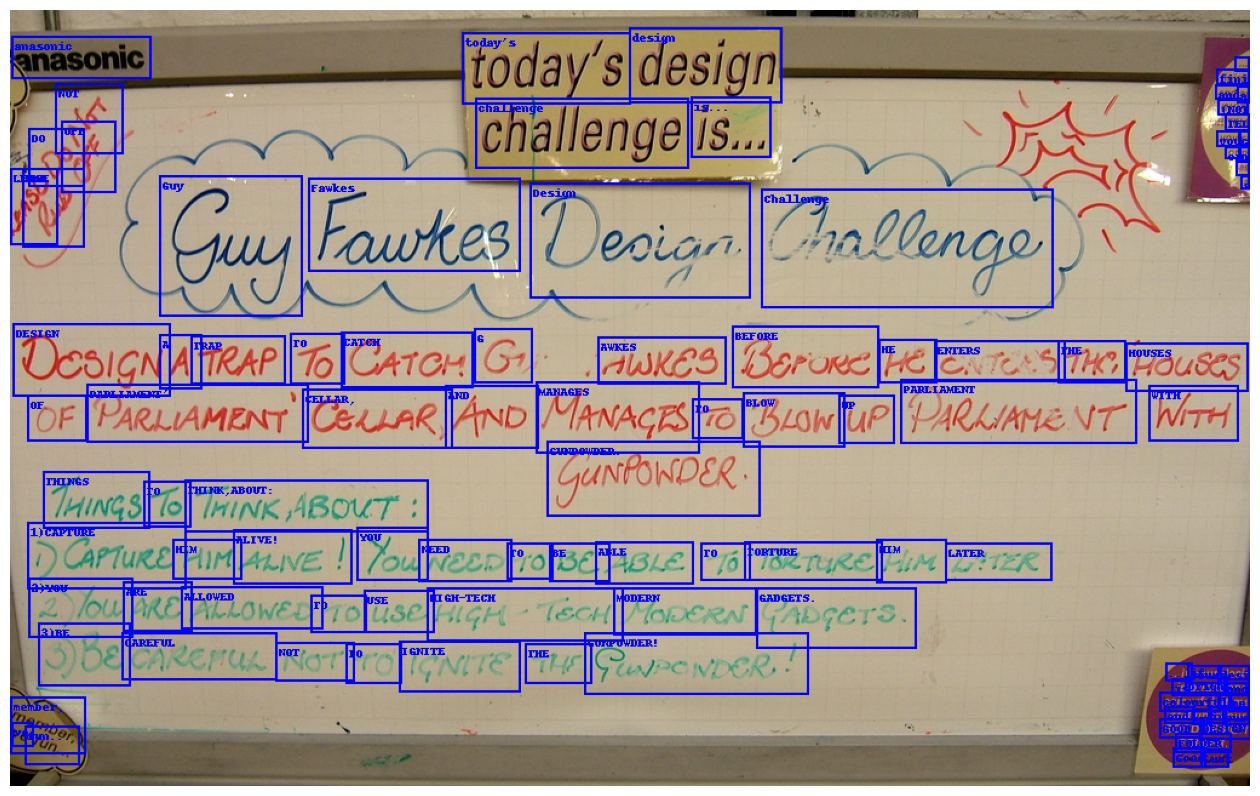

In [14]:
plot_image(image, boxes, labels)

# Model

## Backbone VGG16

In [15]:
# VGG Backbone
class VGGBase(nn.Module):
    def __init__(self):
        super(VGGBase, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        # transform FC layers to Conv2d
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
        
        self.load_pretrained_layers()
        
    def forward(self, image):
        # input (N, 3, 300, 300)
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)
        
        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)
        
        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38)
        
        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # first head
        out = self.pool4(out)  # (N, 512, 19, 19)
        
        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19)
        
        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)
        out = F.relu(self.conv7(out))  # (N, 1024, 19, 19)
        conv7_feats = out  # second head
        
        return conv4_3_feats, conv7_feats
    
    # load weights from ImageNet and reshape for FC layers
    def load_pretrained_layers(self):
        
        # our model
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())
        
        # pretrained state_dict
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())
        
        # write pretrained params in our model without FC6, FC7 
        for i, param in enumerate(param_names[:-4]):
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]
            
        # FC6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']
        
        # reshape (4096, 512, 7, 7) -> (1024, 512, 3, 3)
        state_dict['conv6.weight'] = self.decimate(conv_fc6_weight, m=[4, None, 3, 3])
        state_dict['conv6.bias'] = self.decimate(conv_fc6_bias, m=[4])
        
        # FC7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']
        
        # reshape (4096, 4096, 1, 1) -> (1024, 1024, 1, 1)
        state_dict['conv7.weight'] = self.decimate(conv_fc7_weight, m=[4, 4, None, None])
        state_dict['conv7.bias'] = self.decimate(conv_fc7_bias, m=[4])
        
        self.load_state_dict(state_dict)
        print('state_dict loaded')
        
    @staticmethod
    def decimate(input_tensor, m: list):
        # select each m-th value
        assert input_tensor.dim() == len(m)
        for dim in range(input_tensor.dim()):
            if m[dim] is not None:
                input_tensor = input_tensor.index_select(
                    dim=dim,
                    index=torch.arange(
                        start=0,
                        end=input_tensor.size(dim),
                        step=m[dim]
                    ).long()
                )
        return input_tensor

In [16]:
x = torch.randn(1, 3, 300, 300)

In [17]:
x.shape

torch.Size([1, 3, 300, 300])

In [18]:
vgg_base = VGGBase()

state_dict loaded


In [19]:
vgg_base(x)[1].shape

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


torch.Size([1, 1024, 19, 19])

In [20]:
sum([param.numel() for param in vgg_base.parameters() if param.requires_grad])

20483904

## AuxiliaryConvolutions

In [21]:
class AuxiliaryConvolutions(nn.Module):
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()
        
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2)
        
        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)
        
        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        
        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        
    def forward(self, conv7_feats):
        # input (N, 1024, 19, 19)
        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feat = out
        
        out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out
        
        out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out
        
        out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        out = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)
        conv11_2_feats = out
        
        return conv8_2_feat, conv9_2_feats, conv10_2_feats, conv11_2_feats

In [22]:
aux_conv = AuxiliaryConvolutions()

In [23]:
vgg_out = vgg_base(x)
aux_out = aux_conv(vgg_out[1])
(
    vgg_out[0].shape,
    vgg_out[1].shape,
    aux_out[0].shape,
    aux_out[1].shape,
    aux_out[2].shape,
    aux_out[3].shape
)

(torch.Size([1, 512, 38, 38]),
 torch.Size([1, 1024, 19, 19]),
 torch.Size([1, 512, 10, 10]),
 torch.Size([1, 256, 5, 5]),
 torch.Size([1, 256, 3, 3]),
 torch.Size([1, 256, 1, 1]))

In [24]:
sum([param.numel() for param in aux_conv.parameters() if param.requires_grad])

2459520

## PredictionConvolutions

In [25]:
# predictions for EACH priors
class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes: int):
        super(PredictionConvolutions, self).__init__()
        self.n_classes = n_classes
        
        n_boxes = {
            'conv4_3': 4,
            'conv7': 6,
            'conv8_2': 6,
            'conv9_2': 6,
            'conv10_2': 4,
            'conv11_2': 4,
        }
        
        # convolutions for localization
        self.loc_conv4_3  = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7    = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2  = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2  = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)
        
        # convolutions for classification
        self.cl_conv4_3  = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7    = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2  = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2  = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)
        
    def forward(self,
                conv4_3_feats,
                conv7_feats,
                conv8_2_feats,
                conv9_2_feats,
                conv10_2_feats,
                conv11_2_feats,
               ):
        batch_size = conv4_3_feats.size(0)
        
        # localization and reshape
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()  # (N, 38, 38, 16)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 5776, 4)
        
        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4)
        
        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)
        
        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)
        
        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 24, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 24)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)
        
        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)
        
        # classification and reshape
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous()  # (N, 38, 38, 4 * n_classes)
        c_conv4_3 = c_conv4_3.view(batch_size, -1, self.n_classes)  # (N, 5776, n_classes)
        
        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1, self.n_classes)  # (N, 2166, n_classes)
        
        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)
        
        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)
        
        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 6 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 6 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)
        
        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)
        
        # concat results
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)
        
        return locs, classes_scores

In [26]:
pred_conv = PredictionConvolutions(3)

In [27]:
pred_conv(*[*vgg_out] + [*aux_out])[0].shape

torch.Size([1, 8732, 4])

## SSD

In [28]:
class SSD300_(nn.Module):
    def __init__(self, n_classes):
        super(SSD300_, self).__init__()
        self.n_classes = n_classes
        
        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)
        
        self.priors_cxcy = self.create_prior_boxes()
        
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))
        nn.init.constant_(self.rescale_factors, 20)
        
    def create_prior_boxes(self):
        fmap_dims = {
            'conv4_3': 38,
            'conv7': 19,
            'conv8_2': 10,
            'conv9_2': 5,
            'conv10_2': 3,
            'conv11_2': 1,
        }
        
        obj_scales = {
            'conv4_3': 0.1,
            'conv7': 0.2,
            'conv8_2': 0.375,
            'conv9_2': 0.55,
            'conv10_2': 0.725,
            'conv11_2': 0.9,
        }
        
        aspect_ratios = {
            'conv4_3': [1., 2., 0.5],
            'conv7': [1., 2., 3., 0.5, 0.333],
            'conv8_2': [1., 2., 3., 0.5, 0.333],
            'conv9_2': [1., 2., 3., 0.5, 0.333],
            'conv10_2': [1., 2., 0.5],
            'conv11_2': [1., 2., 0.5],
        }
        
        prior_boxes = []
        fmaps = list(fmap_dims.keys())
        
        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]
                    
                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])
        prior_boxes = torch.FloatTensor(prior_boxes).to(device)
        prior_boxes.clamp_(0, 1)

        return prior_boxes

    def forward(self, image):
        conv4_3_feats, conv7_feats = self.base(image)
        
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)
        
        conv8_2_feat, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(conv7_feats)
        locs, classes_scores = self.pred_convs(
            conv4_3_feats,
            conv7_feats,
            conv8_2_feat,
            conv9_2_feats,
            conv10_2_feats,
            conv11_2_feats,
        )
        
        return locs, classes_scores

In [29]:
ssd = SSD300_(3)

state_dict loaded


In [30]:
ssd.create_prior_boxes(), ssd.create_prior_boxes().shape

(tensor([[0.0132, 0.0132, 0.1000, 0.1000],
         [0.0132, 0.0132, 0.1414, 0.1414],
         [0.0132, 0.0132, 0.1414, 0.0707],
         ...,
         [0.5000, 0.5000, 1.0000, 1.0000],
         [0.5000, 0.5000, 1.0000, 0.6364],
         [0.5000, 0.5000, 0.6364, 1.0000]]),
 torch.Size([8732, 4]))

In [31]:
ssd(x)[0].shape, ssd(x)[1].shape

(torch.Size([1, 8732, 4]), torch.Size([1, 8732, 3]))

## MultiBox Loss

In [32]:
#Вспомогательные функции
# (c_x, c_y, w, h) -> (x_min, y_min, x_max, y_max)
def cxcy_to_xy(cxcy):
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max

# (c_x, c_y, w, h) -> (g_c_x, g_c_y,  g_w, g_h)
def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10), 
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1) 

# (g_c_x, g_c_y,  g_w, g_h) -> (c_x, c_y, w, h)
def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2], 
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)
    
# (x_min, y_min, x_max, y_max) -> (c_x, c_y, w, h)
def xy_to_cxcy(xy):
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h


def find_intersection(set_1, set_2):
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0)) 
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0) 
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1] 


def find_jaccard_overlap(set_1, set_2):
    intersection = find_intersection(set_1, set_2) 
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])

    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection 
    return intersection / union

In [33]:
class MultiBoxLoss(nn.Module):
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()

        self.priors_cxcy = priors_cxcy  # якори в относительных координатах
        self.priors_xy = cxcy_to_xy(priors_cxcy)  # якори в абсолютных координатах
        self.threshold = threshold  # порог на матчинг с ground truth
        self.neg_pos_ratio = neg_pos_ratio  # отношение negative/positive примеров
        self.alpha = alpha  # вес для потерь на локализации

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)

        #каждую картинку отдельно обрабатываем
        for i in range(batch_size):
            n_objects = boxes[i].size(0)  # ground truth
            overlap = find_jaccard_overlap(boxes[i].to(device), self.priors_xy)  # (n_objects, 8732)
            
            # для каждого якоря найти наилучший GT
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)
            
            # нужен матч со ВСЕМИ GT на картинке, есть 2 плохих сценария
            # 1) объект ни для одного якоря не оказался лучшим
            # 2) ни один якорь не пересекся с объектом на IoU > threshold
            
            # назначим каждому объекту наиболее сматченный якорь (п.1)
            _, prior_for_each_object = overlap.max(dim=1)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)
            
            # для них искусственно поставим IoU 1, чтобы не отсеять далее (п.2)
            overlap_for_each_prior[prior_for_each_object] = 1.
            
            # находим классы для каждого якоря
            label_for_each_prior = labels[i][object_for_each_prior]
            
            # выкидываем в background тех, кто не прошел порог (label 0)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0
            
            # вытаскиваем финальные предикты якорей
            true_classes[i] = label_for_each_prior
            
            # переводим центральные координаты GT в форму для регрессии
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]).to(device), self.priors_cxcy)  # (8732, 4)
        
        # находим positive якори
        positive_priors = true_classes != 0

        # LOCALIZATION LOSS
        # считаем только для positive якорей
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  #scalar

        # CONFIDENCE LOSS
        # считаем по всем поситивным примерам и по самым негативным
        n_positives = positive_priors.sum(dim=1)
        n_hard_negatives = self.neg_pos_ratio * n_positives

        # считаем loss всех якорей, чтобы потом из них выбрать
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))
        conf_loss_all = conf_loss_all.view(batch_size, n_priors) 
        
        # выбираем positive
        conf_loss_pos = conf_loss_all[positive_priors]
        
        # hard negative берем как топ по loss после сортировки
        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_priors] = 0.  
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)

        # тензор с ранжированными negative примерами
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)
        # маска самых негативных
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)
        # берем loss только с hard negative
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]

        # нормировка на чисто только positive
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()

        return conf_loss + self.alpha * loc_loss

## SSD detect objects

In [34]:
class SSD300(SSD300_):
  #добавим функцию для детектирования
    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        
        #в архитектуре как всегда нет softmax, добавляем его только на inference 
        #чтобы увидеть вероятности
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        #копилки для результатов на батч
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            #делаем декодинг в xy 
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), координаты дробные по отношению к размеру картинки

            #копилки для результатов на картинку
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # для каждого класса КРОМЕ bgr
            for c in range(1, self.n_classes):
                # отсеиваем по min_score неуверенные детекции
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score 
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue

                # оставляем скоры и локализацию только уверенных детекций    
                class_scores = class_scores[score_above_min_score]  # (n_min_score)
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_min_score, 4)

                # сортируем списки по score
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_min_score), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # посчитаем IoU между предсказаниями
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # заводим тензор чтобы следить что выкинем что оставим
                # 1 = suppress, 0 = don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # смотрим боксы от самого уверенного по убыванию
                for box in range(class_decoded_locs.size(0)):
                    # если уже решили удалить, continue
                    if suppress[box] == 1:
                        continue

                    #удалим те что сильно сматчились
                    suppress = suppress | (overlap[box] > max_overlap)
                    suppress[box] = 0

                #достанем что осталось
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # если ни одного бокса не осталось - всё фон
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # конкатим по всем объектам
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # можем ограничить общее число объектов на картинке число top_k
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # и добавим в общую копилку
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores

# Test TextOCR

## Model init

In [35]:
ssd2 = SSD300(2)

state_dict loaded


In [36]:
# checkpoint = torch.load('Downloads/checkpoint_ssd300_pascal_voc.pth', map_location=device)

In [37]:
# new_weights = {}
# for key in ssd2.state_dict():
#     if "pred_convs" not in key:
#         new_weights[key] = checkpoint['state_dict'][key]
#     else:
#         new_weights[key] = ssd2.state_dict()[key]

In [38]:
# ssd2.load_state_dict(new_weights)

In [39]:
freeze_layers = [
    'base.conv1_1.weight', 'base.conv1_1.bias', 'base.conv1_2.weight', 'base.conv1_2.bias',
    'base.conv2_1.weight', 'base.conv2_1.bias', 'base.conv2_2.weight', 'base.conv2_2.bias',
    'base.conv3_1.weight', 'base.conv3_1.bias', 'base.conv3_2.weight', 'base.conv3_2.bias', 'base.conv3_3.weight', 'base.conv3_3.bias', 
    'base.conv4_1.weight', 'base.conv4_1.bias', 'base.conv4_2.weight', 'base.conv4_2.bias', 'base.conv4_3.weight', 'base.conv4_3.bias',
    'base.conv5_1.weight', 'base.conv5_1.bias', 'base.conv5_2.weight', 'base.conv5_2.bias', 'base.conv5_3.weight', 'base.conv5_3.bias',
]

In [40]:
for name, param in ssd2.named_parameters():
    if (name in freeze_layers) and (param.requires_grad):
        param.requires_grad = False

## Dataset prepair

In [41]:
label_to_class = {"background": 0, "text": 1}
class_to_label = {val: key for key, val in label_to_class.items()}

In [42]:
train_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [43]:
train_dataset = TextOCR(train_anot, 'Downloads/', transforms=train_transforms)
val_dataset = TextOCR(val_anot, 'Downloads/', transforms=train_transforms)

In [44]:
def collate_fn(batch):
    images = []
    boxes = []
    labels = []
    
    for row in batch:
        image, box, label = row
        label = torch.tensor([1 for _ in label], dtype=torch.int64)
        images.append(image)
        boxes.append(box)
        labels.append(label)
    
    return torch.stack(images, dim=0), boxes, labels

In [45]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [46]:
for batch in train_loader:
    print(batch[0].shape)
    print(batch[2])
    break

torch.Size([8, 3, 300, 300])
[tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1])]


## Train

In [47]:
n_epochs = 2

optimizer = torch.optim.SGD(ssd2.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=int(len(train_dataset)/batch_size + 1)*n_epochs
                                                      )
criterion = MultiBoxLoss(ssd2.priors_cxcy)

/usr/local/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [48]:
def train(model: nn.Module,
          training_data_loader: DataLoader,
          criterion: nn.Module,
          optimizer: torch.optim.Optimizer,
          scheduler,
          device: str,
          epoch: int,
          step_verbose: int = 30
          ) -> (float, float, float):
    train_loss = 0.0
    idx = 0
    
    total_det_boxes = []
    total_det_labels = []
    total_det_scores = []
    
    total_true_boxes = []
    total_true_labels = []

    model.train()
    for batch in tqdm(training_data_loader, total=len(training_data_loader)):
        image, boxes, labels = batch
        
        batch_imgs = image.to(device)
        batch_boxes = [b.to(device) for b in boxes]
        batch_labels = [l.to(device) for l in labels]
        
        # eval loss
        locs, scores = model(batch_imgs)
        loss = criterion(locs, scores, batch_boxes, batch_labels)
        
        optimizer.zero_grad()
        train_loss += loss.item()
        loss.backward()

        optimizer.step()
        scheduler.step()

        # eval metrics
        # ToDo
        
        idx += 1
        if idx % step_verbose == 0:
            print(f'Epoch: {epoch}, loss: {train_loss / idx}')
        
    train_loss /= len(training_data_loader)

    return train_loss

In [49]:
train_losses = []
for epoch in range(n_epochs):
    loss = train(ssd2, val_loader, criterion, optimizer, scheduler, device, epoch)
    train_losses.append(loss)

  8%|███▏                                      | 30/391 [03:23<42:06,  7.00s/it]

Epoch: 0, loss: 6.19218651453654


 15%|██████▍                                   | 60/391 [06:57<38:27,  6.97s/it]

Epoch: 0, loss: 5.889940142631531


 23%|█████████▋                                | 90/391 [10:36<34:46,  6.93s/it]

Epoch: 0, loss: 5.697641187243992


 31%|████████████▌                            | 120/391 [14:09<32:40,  7.24s/it]

Epoch: 0, loss: 5.562315229574839


 38%|███████████████▋                         | 150/391 [17:40<27:39,  6.89s/it]

Epoch: 0, loss: 5.4360170078277585


 46%|██████████████████▊                      | 180/391 [21:10<24:57,  7.10s/it]

Epoch: 0, loss: 5.353376650810242


 54%|██████████████████████                   | 210/391 [24:37<21:02,  6.98s/it]

Epoch: 0, loss: 5.30284415880839


 61%|█████████████████████████▏               | 240/391 [28:04<17:28,  6.94s/it]

Epoch: 0, loss: 5.235372841358185


 69%|████████████████████████████▎            | 270/391 [31:29<13:35,  6.74s/it]

Epoch: 0, loss: 5.169551831704599


 77%|███████████████████████████████▍         | 300/391 [34:53<10:11,  6.72s/it]

Epoch: 0, loss: 5.116643419265747


 84%|██████████████████████████████████▌      | 330/391 [38:36<07:41,  7.56s/it]

Epoch: 0, loss: 5.133298352270415


 92%|█████████████████████████████████████▋   | 360/391 [42:10<03:32,  6.87s/it]

Epoch: 0, loss: 5.137366367710961


100%|████████████████████████████████████████▉| 390/391 [45:39<00:06,  6.80s/it]

Epoch: 0, loss: 5.099885346339299


  8%|███▏                                      | 30/391 [03:29<41:56,  6.97s/it]

Epoch: 1, loss: 4.398052374521892


 15%|██████▍                                   | 60/391 [06:54<37:41,  6.83s/it]

Epoch: 1, loss: 4.387152274449666


 23%|█████████▋                                | 90/391 [10:26<37:43,  7.52s/it]

Epoch: 1, loss: 4.381224536895752


 31%|████████████▌                            | 120/391 [14:37<36:58,  8.19s/it]

Epoch: 1, loss: 4.437998004754385


 38%|███████████████▋                         | 150/391 [18:40<32:10,  8.01s/it]

Epoch: 1, loss: 4.4375117333730065


 46%|██████████████████▊                      | 180/391 [22:37<27:41,  7.87s/it]

Epoch: 1, loss: 4.409687178664737


 54%|██████████████████████                   | 210/391 [26:37<24:07,  8.00s/it]

Epoch: 1, loss: 4.393067613102141


 61%|█████████████████████████▏               | 240/391 [30:31<19:49,  7.88s/it]

Epoch: 1, loss: 4.365377815564473


 69%|████████████████████████████▎            | 270/391 [34:32<15:50,  7.86s/it]

Epoch: 1, loss: 4.3341851834897644


 77%|███████████████████████████████▍         | 300/391 [38:29<12:03,  7.95s/it]

Epoch: 1, loss: 4.306700090567271


 84%|██████████████████████████████████▌      | 330/391 [42:27<08:12,  8.07s/it]

Epoch: 1, loss: 4.296040039351492


 92%|█████████████████████████████████████▋   | 360/391 [46:24<04:00,  7.77s/it]

Epoch: 1, loss: 4.292279071278042


100%|████████████████████████████████████████▉| 390/391 [50:18<00:07,  7.71s/it]

Epoch: 1, loss: 4.293473610511193


100%|█████████████████████████████████████████| 391/391 [50:22<00:00,  7.73s/it]


In [50]:
train_losses

[5.097613905396913, 4.292265243237586]

## Visualize

In [51]:
img_id = '0a2e7e1ac12be6fe'

In [52]:
img_path = f'Downloads/train_images/{img_id}.jpg'
original_image = Image.open(img_path).convert('RGB')

img = train_transforms(original_image).to(device)
img = img[None, :]

In [77]:
locs, scores = ssd2(img)
det_boxes, det_labels, det_scores = ssd2.detect_objects(
    locs.detach(), scores.detach(), min_score=0.5, max_overlap=0.2, top_k=20)

/var/folders/3p/wz2sjqtx3vz8szc7z3qdgtl4fvlwb6/T/ipykernel_2456/923913995.py:66: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/var/folders/3p/wz2sjqtx3vz8szc7z3qdgtl4fvlwb6/T/ipykernel_2456/923913995.py:68: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  image_scores.append(class_scores[1 - suppress])


In [78]:
original_dims = torch.FloatTensor([original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0).to(device)
det_boxes = det_boxes[0] * original_dims
det_labels = [class_to_label[l] for l in det_labels[0].to('cpu').tolist()]

/var/folders/3p/wz2sjqtx3vz8szc7z3qdgtl4fvlwb6/T/ipykernel_2456/3370322586.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.uint8, requires_grad=False)


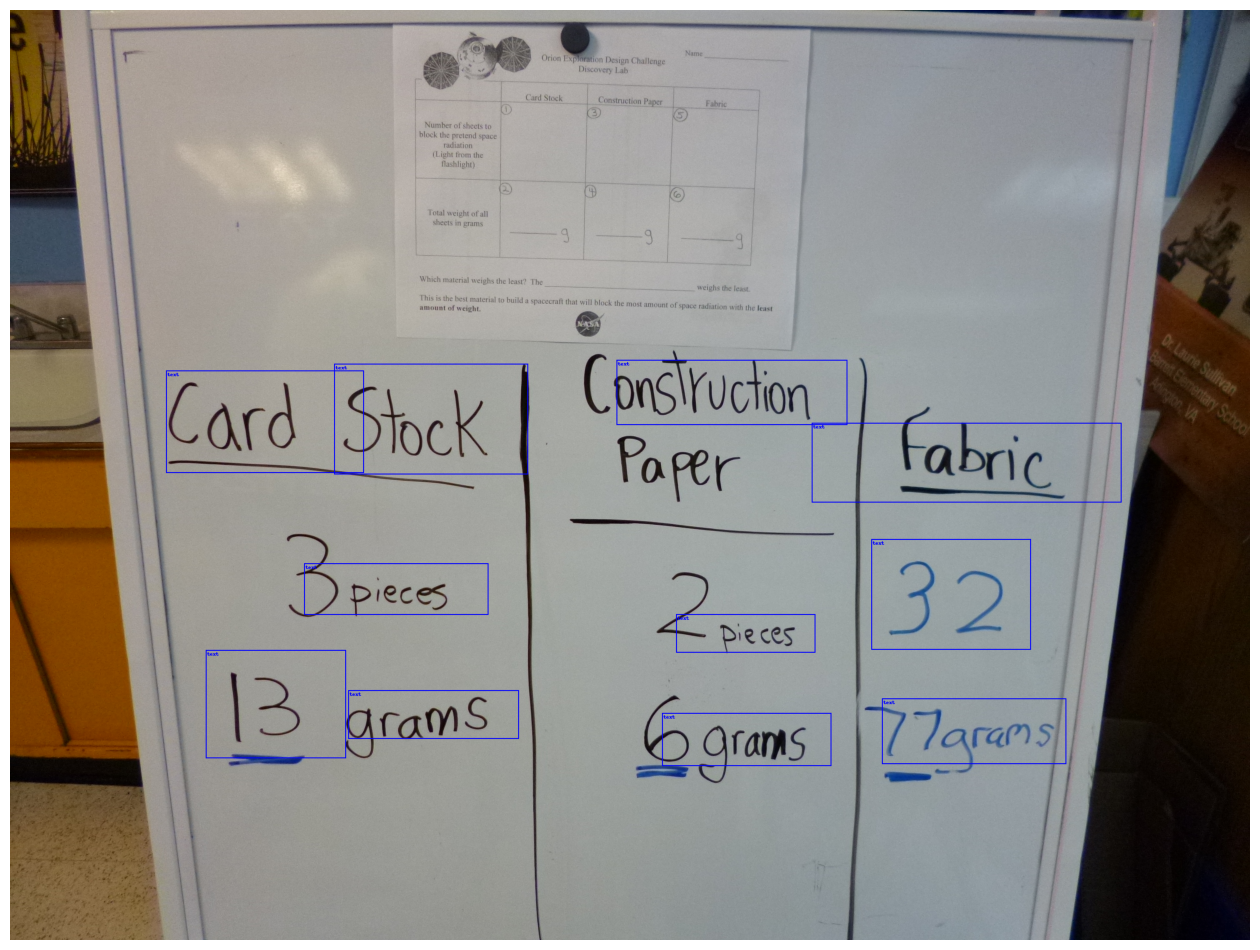

In [79]:
plot_image(original_image, det_boxes, det_labels)